In [1]:
import pandas as pd

# crearea dataFrame-ului
data = pd.read_csv('date_promovare_examen.csv')
data.head()

,Ore_Studiu,Ore_Somn,Promovare
0,6.50,8.46,1
1,5.86,8.95,1
2,6.65,7.30,1
3,7.52,8.28,1
4,5.77,7.67,1


In [2]:
# Verificam daca exista valori lipsa
print('Numarul valorilor lipsa pentru fiecare variabila:')
print(data.isnull().sum())

Numarul valorilor lipsa pentru fiecare variabila:
Ore_Studiu    0
Ore_Somn      0
Promovare     0
dtype: int64


In [3]:
# Numărul de duplicate
num_duplicates = data.duplicated().sum()
print("Număr de duplicate:", num_duplicates)

Număr de duplicate: 1


a)

In [4]:
Y = data['Promovare'].values
X1 = data['Ore_Studiu'].values
X2 = data['Ore_Somn'].values

# Verificare balansare date
proportion = Y.mean()  # Procentul de studenti promovati
print("Proporție promovați:", proportion)

Proporție promovați: 0.5


Media valorilor persoanelor promovate este 0.5, ceea ce inseamna ca jumatate din oameni au promovat, iar jumatate nu au promovat.

In [17]:
import pymc as pm
import arviz as az
import numpy as np

# normalizarea datelor
X1 = (X1 - X1.mean()) / X1.std()
X2 = (X2 - X2.mean()) / X2.std()

with pm.Model() as model:
    # Priori
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=1)
    beta2 = pm.Normal('beta2', mu=0, sigma=1)
    
    # Linear predictor
    mu = alpha + beta1 * X1 + beta2 * X2
    
    # Probabilitate logistică
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    
    # Frontiera de decizie (punctul în care probabilitatea = 0.5)
    bd = pm.Deterministic('bd', -(alpha + beta1 * X1) / beta2)

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=Y)
    
    # Sampling MCMC
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


b)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15748\4097587704.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  bd_hdi = az.hdi(bd_samples_flat, hdi_prob=0.94)  # shape: (N, 2)


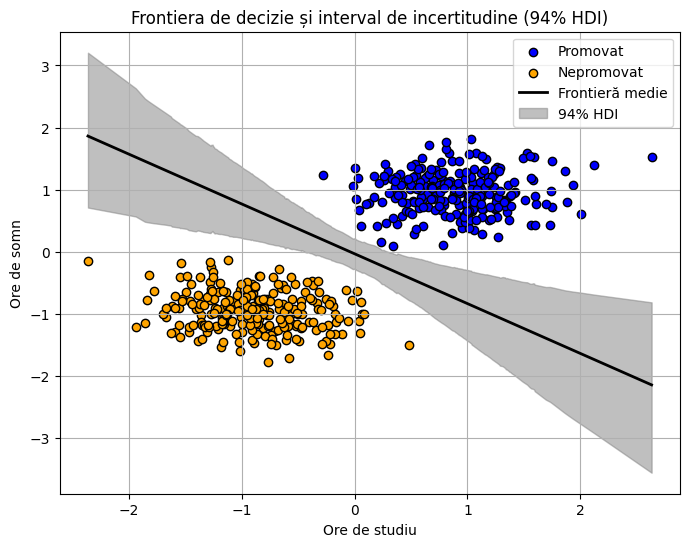

In medie, valoarea granitei de decizie este: -0.033213003318894985


In [18]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Extragem esantioane a posteriori din bd
bd_samples = idata.posterior['bd'].values  # shape: (chains, draws, N)

# Aplatizăm pe dimensiunile chain și draw:
bd_samples_flat = bd_samples.reshape(-1, bd_samples.shape[-1])  # (total_samples, N)

# Calculam media și HDI pentru fiecare punct din date
bd_mean = bd_samples_flat.mean(axis=0)
bd_hdi = az.hdi(bd_samples_flat, hdi_prob=0.94)  # shape: (N, 2)

bd_lower = bd_hdi[:,0]
bd_upper = bd_hdi[:,1]

# Sortăm valorile în funcție de X1 pentru a putea trasa o linie continuită
sort_idx = np.argsort(X1)
X1_sorted = X1[sort_idx]
bd_mean_sorted = bd_mean[sort_idx]
bd_lower_sorted = bd_lower[sort_idx]
bd_upper_sorted = bd_upper[sort_idx]

# Reprezentăm datele: 
# ipotetic, studenții promovați cu albastru și cei nepromovați cu portocaliu
plt.figure(figsize=(8,6))
plt.scatter(X1[Y==1], X2[Y==1], color='blue', edgecolor='black', label='Promovat')
plt.scatter(X1[Y==0], X2[Y==0], color='orange', edgecolor='black', label='Nepromovat')

# Reprezentăm linia frontierei (media)
plt.plot(X1_sorted, bd_mean_sorted, color='black', lw=2, label='Frontieră medie')

# Reprezentăm intervalul HDI
plt.fill_between(X1_sorted, bd_lower_sorted, bd_upper_sorted, color='gray', alpha=0.5, label='94% HDI')

plt.xlabel('Ore de studiu')
plt.ylabel('Ore de somn')
plt.title('Frontiera de decizie și interval de incertitudine (94% HDI)')
plt.grid(True)
plt.legend()
plt.show()

bd_mean = bd_samples.mean()
print(f'In medie, valoarea granitei de decizie este: {bd_mean}')

c)

In [22]:
beta1_samples = idata.posterior['beta1'].values.flatten()
beta2_samples = idata.posterior['beta2'].values.flatten()

print(f'Beta1 = {np.abs(beta1_samples.mean())}')
print(f'Beta2 = {np.abs(beta2_samples.mean())}')



Beta1 = 2.7387205558749
Beta2 = 3.5870202634610027


Se observa ca modulul valorilor medii pentru beta1 este 2.73, iar pentru beta2 este 3.58. Din acest lucru se poate spune ca al doilea coeficient este mai mare, deci are o influenta mai mare. Prin urmare, numarul orelor de somn influenteaza mai mult promovabilitatea.